In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_J, R_Sun

R_s = 0.42*R_Sun
T_s = 3600
log_g_s = 4.85
Met_s = -0.5

star = create_star(R_s, T_s, log_g_s, Met_s)

planet_name = 'TOI-1266 c'
R_p = 0.139*R_J
T_eq = 345.87
g_p = 8.87769

planet = create_planet(planet_name, R_p, gravity=g_p, T_eq=T_eq)

/home/swaroop/anaconda3/envs/poseidon/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /home/swaroop/sample/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/swaroop/POSEIDON/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import define_model, read_opacities, make_atmosphere, compute_spectrum
import numpy as np

model_name = '95% H2O 5%CO2'

bulk_species = ['H2O']
param_species = ['CO2']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1         # 1 bar
R_p_ref = R_p         # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T_eq])              # Assume terminator temperature is T_eq
log_X_params = np.array([-1.3010])   # CO2 H2 log abundances in model
                    #N2% 3.5
# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

In [3]:
atmosphere.keys()

dict_keys(['P', 'T', 'g', 'n', 'r', 'r_up', 'r_low', 'dr', 'P_surf', 'X', 'X_active', 'X_CIA', 'X_ff', 'X_bf', 'mu', 'N_sectors', 'N_zones', 'alpha', 'beta', 'phi', 'theta', 'phi_edge', 'theta_edge', 'dphi', 'dtheta', 'kappa_cloud_0', 'P_cloud', 'f_cloud', 'phi_cloud_0', 'theta_cloud_0', 'a', 'gamma', 'is_physical'])

In [3]:
from POSEIDON.core import wl_grid_constant_R

wl_min = 0.5
wl_max = 5.5
R = 10000

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***Reading Opacities***#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # Same as prior range for T
T_fine_max = 1000    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                       log_P_fine_step)

# Pre-interpolate the opacities (note: model wavelength range was initialised in cell above)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
H2O done
CO2 done
Opacity pre-interpolation complete.


In [12]:
np.savetxt('H2O_with_18.txt',spectrum)

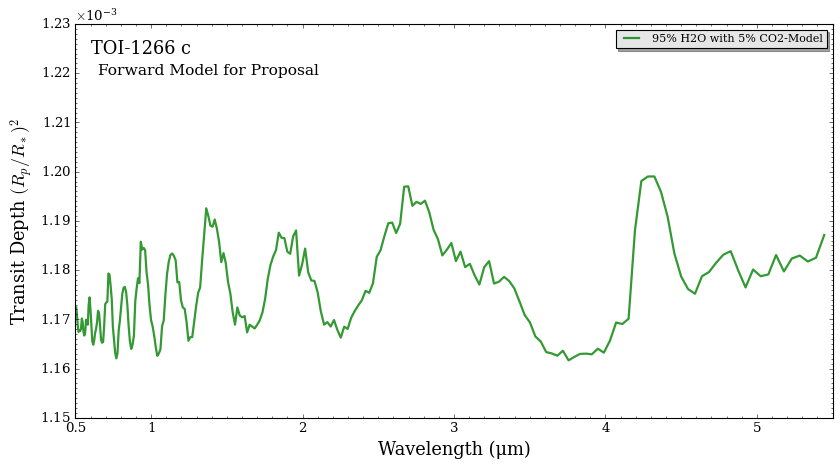

In [5]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')
spectra = []

spectra = plot_collection(spectrum, wl, collection = spectra)

fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, 
                        plot_full_res=False, figure_shape='wide', spectra_labels=['95% H2O with 5% CO2-Model'], plt_label='Forward Model for Proposal', wl_axis='linear')#, y_min=1.148e-3, y_max=1.192e-3)

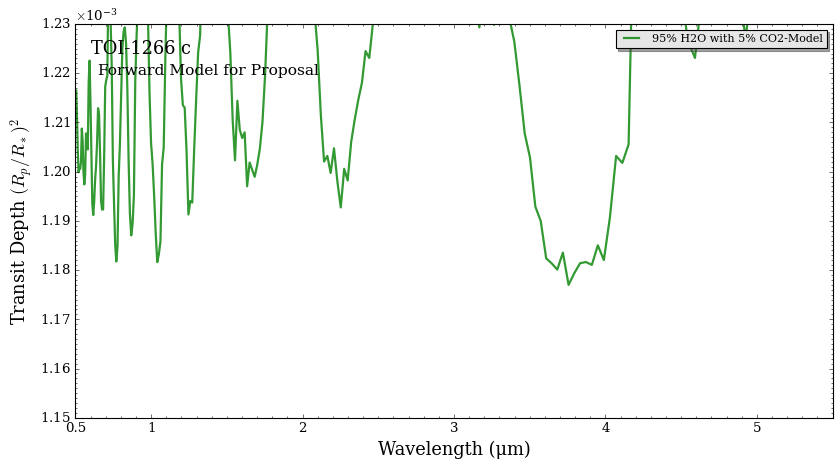

In [5]:
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')
spectra = []

spectra = plot_collection(spectrum, wl, collection = spectra)

fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, 
                        plot_full_res=False, figure_shape='wide', spectra_labels=['95% H2O with 5% CO2-Model'], plt_label='Forward Model for Proposal', wl_axis='linear', y_min=1.15e-3, y_max=1.23e-3)

In [11]:
y18=np.loadtxt('H2O_with_18.txt')

In [12]:
import matplotlib.pyplot as plt

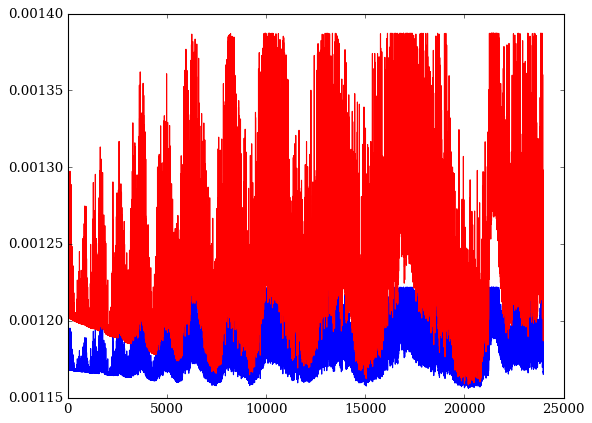

In [13]:
plt.plot(x,y18,'b')
plt.plot(x,spectrum,'r')

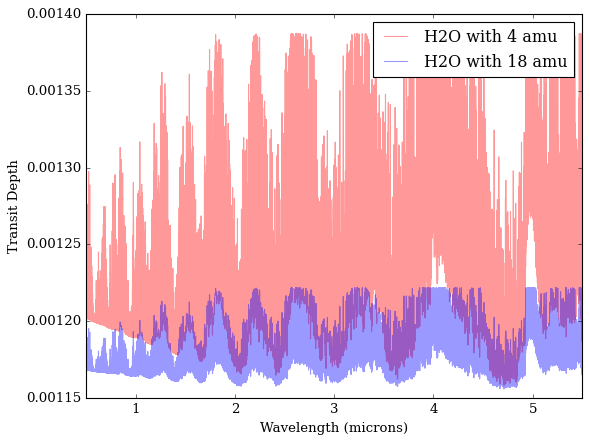

In [20]:
x=np.linspace(0.5, 5.5, len(spectrum))
plt.plot(x,spectrum,'r', alpha=0.4, label='H2O with 4 amu')
plt.plot(x,y18,'b', alpha=0.4, label='H2O with 18 amu')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth')
plt.xlim(0.5,5.5)
plt.legend()
plt.savefig('changing_mass_of_dominant.png',dpi=300)

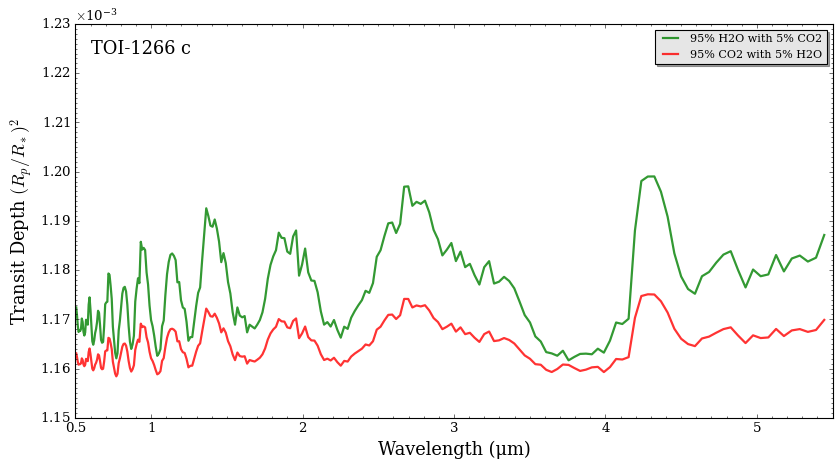

In [5]:
#####TEST CELL FOR H2O feature

bulk_species_a = ['CO2']
param_species_a = ['H2O']

# Create the model object
model_a = define_model(model_name, bulk_species_a, param_species_a,
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')


# Define new mixing ratio array with a low CO2 abundance
log_X_params_no_CH4 = np.array([-1.3010])  # log(H2O)

# Create a new atmosphere without CO2
atmosphere_no_CH4 = make_atmosphere(planet, model_a, P, P_ref, R_p_ref,
                                    PT_params, log_X_params_no_CH4)

# Generate the new transmission spectrum
spectrum_no_CH4 = compute_spectrum(planet, star, model_a, atmosphere_no_CH4,
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_no_CH4, wl, collection = spectra)

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100,
                        spectra_labels = ['95% H2O with 5% CO2','95% CO2 with 5% H2O'], figure_shape='wide', plot_full_res=False, wl_axis='linear')
# high mean molecular weight CO2 makes low transit depth.